In [121]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
import seaborn as sns

In [122]:
plt.style.use("default")
sns.set_theme(
    context="paper",
    style="white",
    palette="tab10",
    font="serif",
    font_scale=1.5,
    color_codes=True,
    rc={"text.usetex": True},
)
os.makedirs("../figures/SCALING/", exist_ok=True)
fig_dir = "../figures/SCALING/"

In [123]:
def load_experiment_data(root_dir: str, lr: float = 0.001) -> pd.DataFrame:
    """Load experiment data from complex directory structure"""
    records = []
    root_path = Path(root_dir)

    # Find all terminal seed directories containing results
    for seed_dir in root_path.glob("**/seed=*/"):
        # Extract parameters from path components
        params = {
            "hidden_size": None,
            "dataset_size": None,
            "lr": None,
            "n_classes": None,
            "seed": int(seed_dir.name.split("=")[1]),
        }

        # Parse parameters from parent directories
        for parent in seed_dir.parents:
            if parent.name.startswith("hidden_size="):
                params["hidden_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("dataset_size="):
                params["dataset_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("lr="):
                params["lr"] = float(parent.name.split("=")[1])
            elif parent.name.startswith("n_classes="):
                params["n_classes"] = int(parent.name.split("=")[1])

        # Validate all parameters found
        if None in params.values():
            missing = [k for k, v in params.items() if v is None]
            print(f"Skipping {seed_dir} - missing: {missing}")
            continue

        try:
            # Load metrics files
            test_losses = np.loadtxt(seed_dir / "test_losses.txt")
            train_losses = np.loadtxt(seed_dir / "train_losses.txt")
            test_accuracies = np.loadtxt(seed_dir / "test_accuracies.txt")
            control = np.loadtxt(seed_dir / "controls.txt")
            epochs = np.loadtxt(seed_dir / "epochs.txt")

            records.append(
                {
                    **params,
                    "test_accuracy": test_accuracies,
                    "test_loss": test_losses,
                    "train_loss": train_losses,
                    "epoch": epochs,
                    "control": control,
                }
            )
        except Exception as e:
            print(f"Error loading {seed_dir}: {str(e)}")
            continue

    return pd.DataFrame(records)

In [124]:
growing_df = load_experiment_data(
    "../output/spiral_classification/task=classification/"
)
baseline_df = load_experiment_data(
    "../output/spiral_classification_baseline/task=classification/"
)

# growing_df = load_experiment_data("../output_old/bessel_regression/")
# baseline_df = load_experiment_data("../output_old/bessel_regression_baseline/")

In [125]:
def calculate_mean_std_across_runs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the mean and standard deviation of array-valued columns
    across different runs, grouping by all *scalar* columns *except* the 'seed' column.
    """

    if "seed" not in df.columns:
        raise ValueError("DataFrame must contain a 'seed' column.")

    array_cols = [col for col in df.columns if isinstance(df[col].iloc[0], np.ndarray)]

    if not array_cols:
        raise ValueError("No array-valued columns found.")

    scalar_cols = [col for col in df.columns if col != "seed" and col not in array_cols]

    def mean(x: pd.Series) -> np.ndarray:
        """Calculates the mean array across runs."""
        return np.mean(np.stack(x.values), axis=0)

    def std(x: pd.Series) -> np.ndarray:
        """Calculates the standard deviation array across runs."""
        return np.std(np.stack(x.values), axis=0)

    grouped = df.groupby(scalar_cols)

    # Calculate the mean and std for each array-valued column
    agg_dict = {col: [mean, std] for col in array_cols}
    result = grouped.agg(agg_dict)

    # Flatten the multi-level column index
    result.columns = [
        "_".join(col).strip() for col in result.columns.values
    ]  # More robust flattening

    return result

In [126]:
processed_growing = calculate_mean_std_across_runs(growing_df)
processed_baseline = calculate_mean_std_across_runs(baseline_df)

In [127]:
lr = 3e-4
dataset_size = 2**15
n_classes = 9

In [128]:
processed_growing

test_accuracy_mean  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [0.33298749327659605, 0.33298749327659605, 0.3...   
                                5          [0.19836715757846832, 0.19836715757846832, 0.1...   
                                7          [0.14259993880987168, 0.14259993880987168, 0.1...   
                                9          [0.11053113639354706, 0.11053113639354706, 0.1...   
                         0.0003 3          [0.33298749327659605, 0.33298749327659605, 0.3...   
...                                                                                      ...   
1024        32768        0.0003 9          [0.11053113639354706, 0.1852411538362503, 0.17...   
                         0.0010 3          [0.33298749327659605, 0.5195453047752381, 0.53...   
                                5          [0.19836715757846832, 0.3182816982269287, 0.32...   
                                7          [0.14259993880987168, 0.22487030774354935, 0.2...   
                                9          [0.11053113639354706, 0.17628205865621566, 0.1...   

                                                                           test_accuracy_std  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [0.005817309233021015, 0.005817309233021015, 0...   
                                5          [0.00279428224468743, 0.00279428224468743, 0.0...   
                                7          [0.0024414469158201583, 0.0024414469158201583,...   
                                9          [0.0035635928327519503, 0.0035635928327519503,...   
                         0.0003 3          [0.005817309233021015, 0.005817309233021015, 0...   
...                                                                                      ...   
1024        32768        0.0003 9          [0.0035635928327519503, 0.0076832925314032794,...   
                         0.0010 3          [0.005817309233021015, 0.004430796992416988, 0...   
                                5          [0.00279428224468743, 0.005066775255122205, 0....   
                                7          [0.0024414469158201583, 0.0038088448405860934,...   
                                9          [0.0035635928327519503, 0.004528106347116474, ...   

                                                                              test_loss_mean  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [1.4451423287391663, 1.4368685126304626, 1.428...   
                                5          [1.960696268081665, 1.9524317979812622, 1.9443...   
                                7          [2.297693943977356, 2.2893450975418093, 2.2811...   
                                9          [2.5583770751953123, 2.549582266807556, 2.5409...   
                         0.0003 3          [1.4449747562408448, 1.4207440972328187, 1.398...   
...                                                                                      ...   
1024        32768        0.0003 9          [2.5172523975372316, 2.4900712728500367, 2.396...   
                         0.0010 3          [1.4181172728538514, 1.0890464425086974, 0.952...   
                                5          [1.9290173411369325, 1.6056715369224548, 1.476...   
                                7          [2.2654674291610717, 1.9451899647712707, 1.822...   
                                9          [2.5167985200881957, 2.195809030532837, 2.0724...   

                                                                               test_loss_std  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [0.01754597111979207, 0.01666550516845924, 0.0...   
                                5      

In [129]:
single_param_growing = processed_growing[
    processed_growing.index.get_level_values("lr") == lr
]
single_param_growing = single_param_growing[
    single_param_growing.index.get_level_values("dataset_size") == dataset_size
]

single_param_growing = single_param_growing[
    single_param_growing.index.get_level_values("n_classes") == n_classes
]


In [130]:
single_param_growing.head()

,,,,test_accuracy_mean,test_accuracy_std,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,n_classes,,,,,,,,,,
4,32768,0.0003,9,"[0.11053113639354706, 0.11053113639354706, 0.1...","[0.0035635928327519503, 0.0035635928327519503,...","[2.5581991910934447, 2.5323935031890867, 2.508...","[0.0072324535683551796, 0.006466572460009223, ...","[2.5571786403656005, 2.5314870357513426, 2.507...","[0.006860647287003963, 0.006108274580622912, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
8,32768,0.0003,9,"[0.11053113639354706, 0.11053113639354706, 0.1...","[0.0035635928327519503, 0.0035635928327519503,...","[2.5377959489822386, 2.514137387275696, 2.4917...","[0.0038108000010853705, 0.003298188356211535, ...","[2.537130880355835, 2.5135852336883544, 2.4913...","[0.003383376043359785, 0.002878630060750061, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
16,32768,0.0003,9,"[0.11053113639354706, 0.11053113639354706, 0.1...","[0.0035635928327519503, 0.0035635928327519503,...","[2.5275396585464476, 2.505327248573303, 2.4837...","[0.0021517826983372744, 0.0017516136145094572,...","[2.5271259784698485, 2.505013608932495, 2.4835...","[0.0016963660412812203, 0.0013355129881701673,...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
32,32768,0.0003,9,"[0.11053113639354706, 0.11053113639354706, 0.1...","[0.0035635928327519503, 0.0035635928327519503,...","[2.5223782062530518, 2.5011309385299683, 2.479...","[0.0013120447007289474, 0.0009811491923768054,...","[2.522142267227173, 2.5009783267974854, 2.4792...","[0.0008702481554867657, 0.0006078804103508979,...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
64,32768,0.0003,9,"[0.11053113639354706, 0.11069902405142784, 0.1...","[0.0035635928327519503, 0.003682063794482957, ...","[2.5197731971740724, 2.499007987976074, 2.4751...","[0.0008534468489713738, 0.0005700787732611049,...","[2.5196625232696532, 2.498951482772827, 2.4751...","[0.0004611756428922839, 0.0002854926010485647,...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."


In [131]:
single_param_baseline = processed_baseline[
    processed_baseline.index.get_level_values("lr") == lr
]
single_param_baseline = single_param_baseline[
    single_param_baseline.index.get_level_values("dataset_size") == dataset_size
]

single_param_baseline = single_param_baseline[
    single_param_baseline.index.get_level_values("n_classes") == n_classes
]

In [132]:
single_param_baseline.head()

,,,,test_accuracy_mean,test_accuracy_std,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,n_classes,,,,,,,,,,
4,32768,0.0003,9,"[0.10325091779232025, 0.10315934158861637, 0.1...","[0.020891394663483644, 0.026420947267988798, 0...","[2.266708016395569, 2.236831879615784, 2.21358...","[0.04680892879310946, 0.038615139773960735, 0....","[2.2653910398483275, 2.2356558799743653, 2.212...","[0.046956265708397595, 0.0386782298988612, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,32768,0.0003,9,"[0.1043498195707798, 0.11385836601257324, 0.14...","[0.020261132048241908, 0.018992605638352728, 0...","[2.2515948534011843, 2.213183069229126, 2.1838...","[0.0181520194726149, 0.01418193040027257, 0.01...","[2.252554488182068, 2.21382794380188, 2.184140...","[0.01823268171848751, 0.014326710063195653, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,32768,0.0003,9,"[0.10868437364697456, 0.14354396089911461, 0.1...","[0.014320510360614411, 0.023866911922903765, 0...","[2.2319056510925295, 2.1773157119750977, 2.135...","[0.022352916764669883, 0.01629147542832912, 0....","[2.229835605621338, 2.1764349699020387, 2.1352...","[0.02133465091851013, 0.016077184932981877, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32,32768,0.0003,9,"[0.0995268639177084, 0.17840354666113853, 0.17...","[0.030608437011756473, 0.028244516446413487, 0...","[2.2373719453811645, 2.143178606033325, 2.0753...","[0.01761104056964904, 0.011111742153558242, 0....","[2.239529752731323, 2.1444307565689087, 2.0760...","[0.01976531955983915, 0.01257570527783631, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
64,32768,0.0003,9,"[0.12492369040846825, 0.18125763833522796, 0.1...","[0.020475134930153963, 0.008636261898047235, 0...","[2.217792105674744, 2.0744547843933105, 1.9822...","[0.019036892082140447, 0.010184930700539429, 0...","[2.2213736295700075, 2.0756442308425904, 1.982...","[0.01906304544366809, 0.01120102878990085, 0.0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [133]:
epochs = single_param_baseline["epoch_mean"].values[0]

In [134]:
single_param_baseline["test_loss_mean"].values

array([array([2.26670802, 2.23683188, 2.21358297, 2.19397991, 2.17630877,
              2.15940647, 2.14257574, 2.12545681, 2.10795395, 2.09016647,
              2.07230487, 2.0546417 , 2.0374604 , 2.02099224, 2.00539243,
              1.99075223, 1.9771183 , 1.96450706, 1.95291625, 1.94233041,
              1.93272203, 1.92405182, 1.9162692 , 1.90931501, 1.90312446,
              1.89762987, 1.89276344, 1.88845886, 1.88465208, 1.88128189,
              1.8782901 , 1.87562201, 1.87322617, 1.87105498, 1.86906415,
              1.86721281, 1.86546335, 1.86378074, 1.86213223, 1.86048691,
              1.8588154 , 1.8570893 , 1.85528145, 1.85336529, 1.85131536,
              1.84910693, 1.84671575, 1.84411875, 1.84129356, 1.83821987]),
       array([2.25159485, 2.21318307, 2.18380399, 2.15795557, 2.13289351,
              2.10752828, 2.08176844, 2.05597479, 2.03068689, 2.00647229,
              1.98385395, 1.96326741, 1.94501305, 1.92921987, 1.91584494,
              1.90471418, 1.89558196

In [135]:
hidden_sizes = single_param_baseline.index.get_level_values("hidden_size").unique()[:]

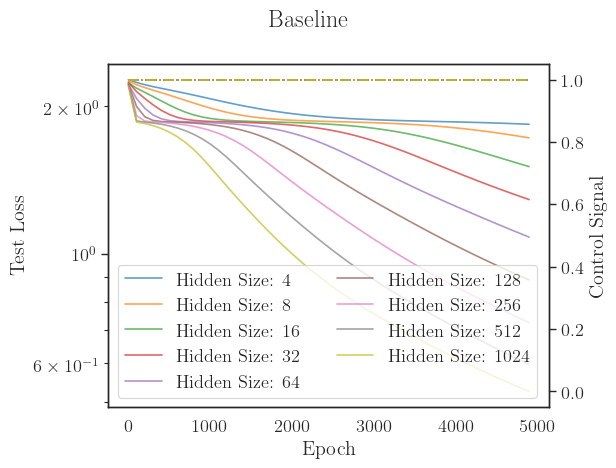

In [136]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_baseline["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_baseline["test_loss_mean"].values[i]
    #     - single_param_baseline["test_loss_std"].values[i],
    #     single_param_baseline["test_loss_mean"].values[i]
    #     + single_param_baseline["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
ax1.legend(loc="best", ncol=2)
# ax1.set_ylim(1e-6, 1)

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_baseline["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Baseline")
plt.tight_layout()

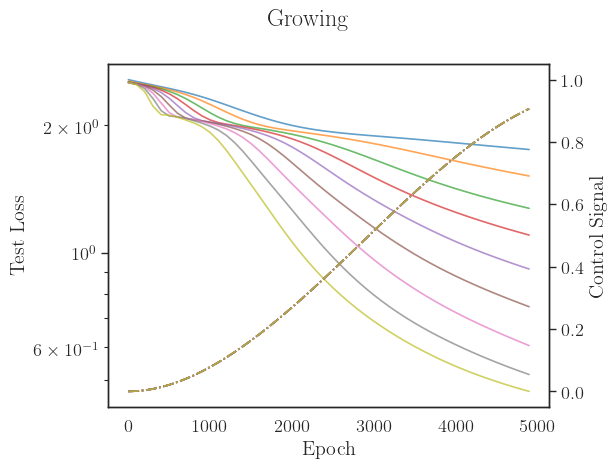

In [137]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_growing["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_growing["test_loss_mean"].values[i]
    #     - single_param_growing["test_loss_std"].values[i],
    #     single_param_growing["test_loss_mean"].values[i]
    #     + single_param_growing["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
# ax1.legend(loc="best")
# ax1.set_ylim(1e-6, 1)

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_growing["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Growing")
plt.tight_layout()

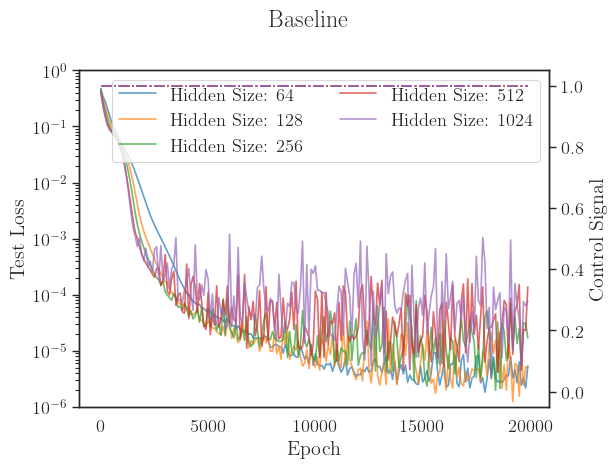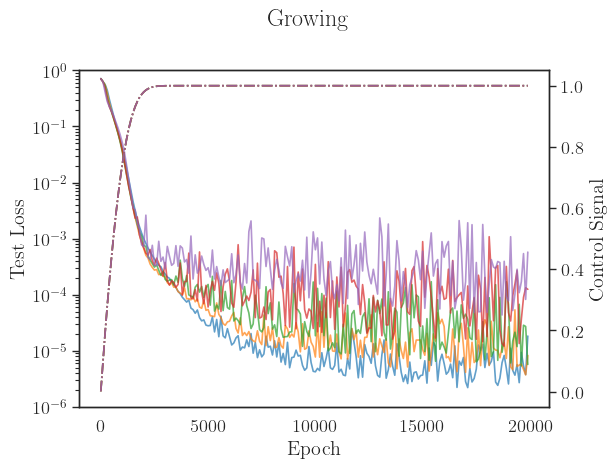

/tmp/ipykernel_370337/1211567928.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


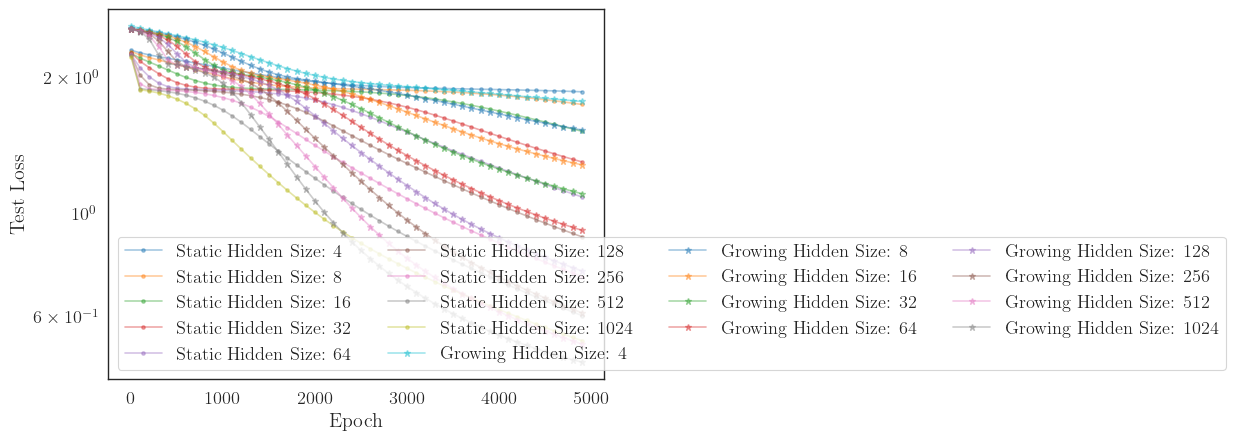

In [138]:
fig, ax1 = plt.subplots()
for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_baseline["test_loss_mean"].values[i],
        ".-",
        label=f"Static Hidden Size: {hidden_sizes[i]}",
        alpha=0.4,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_baseline["test_loss_mean"].values[i]
    #     - single_param_baseline["test_loss_std"].values[i],
    #     single_param_baseline["test_loss_mean"].values[i]
    #     + single_param_baseline["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
# ax1.legend(loc="best")
# ax1.set_ylim(1e-5, 1)

# # Create a second y-axis for the control signal
# ax2 = ax1.twinx()
# for i in range(len(hidden_sizes)):
#     ax2.plot(
#         epochs,
#         single_param_baseline["control_mean"].values[i],
#         "-.",
#         label=f"Hidden Size: {hidden_sizes[i]}",
#     )

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_growing["test_loss_mean"].values[i],
        "*-",
        label=f"Growing Hidden Size: {hidden_sizes[i]}",
        alpha=0.4,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_growing["test_loss_mean"].values[i]
    #     - single_param_growing["test_loss_std"].values[i],
    #     single_param_growing["test_loss_mean"].values[i]
    #     + single_param_growing["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
ax1.legend(loc="best", ncol=4)
# ax1.set_ylim(1e-5, 1)

# # Create a second y-axis for the control signal
# ax2 = ax1.twinx()
# for i in range(len(hidden_sizes)):
#     ax2.plot(
#         epochs,
#         single_param_growing["control_mean"].values[i],
#         "-.",
#         label=f"Hidden Size: {hidden_sizes[i]}",
#         alpha=0.7,
#     )

ax2.set_ylim(-0.05, 1.05)
plt.tight_layout()

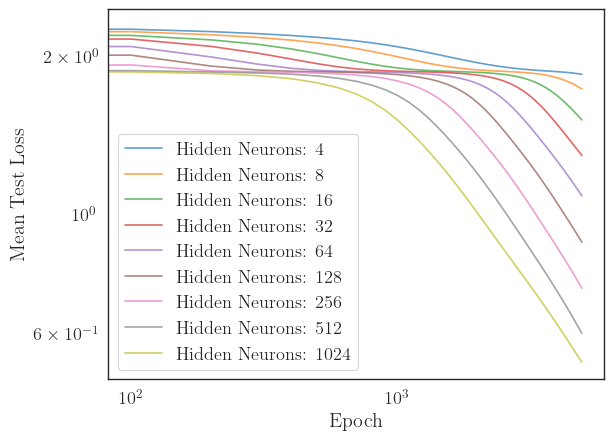

In [139]:
for i, loss in enumerate(single_param_baseline["test_loss_mean"].values):
    plt.plot(epochs, loss, label=f"Hidden Neurons: {hidden_sizes[i]}", alpha=0.7)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Test Loss")
plt.xscale("log")
plt.yscale("log")

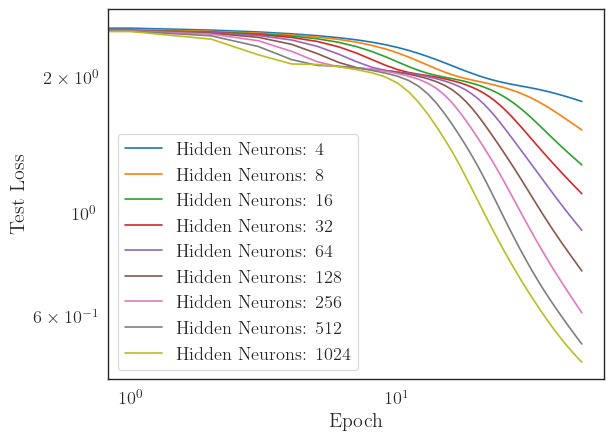

In [140]:
for i, loss in enumerate(single_param_growing["test_loss_mean"].values):
    plt.plot(loss, label=f"Hidden Neurons: {hidden_sizes[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.xscale("log")
plt.yscale("log")

In [141]:
epochs[-1]

np.float64(4900.0)

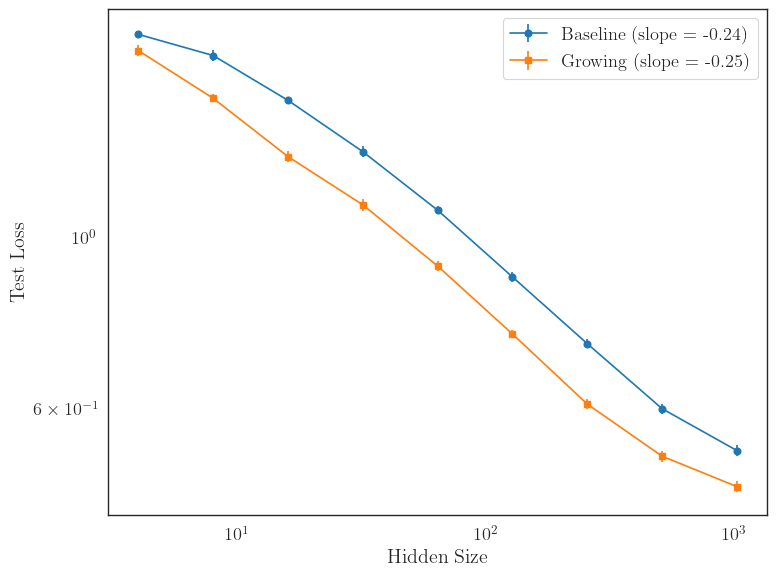

In [142]:
def extract_epoch_test_loss(df):
    return df["test_loss_mean"].apply(lambda x: x[-1]), df["test_loss_std"].apply(
        lambda x: x[-1]
    )


final_loss_baseline, final_loss_baseline_std = extract_epoch_test_loss(
    single_param_baseline
)
final_loss_growing, final_loss_growing_std = extract_epoch_test_loss(
    single_param_growing
)

# Get the hidden sizes associated with each run (they are the first level of the index)
hs_baseline = final_loss_baseline.index.get_level_values("hidden_size").astype(float)
hs_growing = final_loss_growing.index.get_level_values("hidden_size").astype(float)

# Fit a power law (linear fit in log–log coordinates) for each experiment
log_hs_baseline = np.log(hs_baseline)
log_loss_baseline = np.log(final_loss_baseline)
slope_baseline, intercept_baseline = np.polyfit(log_hs_baseline, log_loss_baseline, 1)

log_hs_growing = np.log(hs_growing)
log_loss_growing = np.log(final_loss_growing)
slope_growing, intercept_growing = np.polyfit(log_hs_growing, log_loss_growing, 1)

# Plot the scaling laws with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    hs_baseline,
    final_loss_baseline,
    yerr=final_loss_baseline_std,
    fmt="o-",
    label=f"Baseline (slope = {slope_baseline:.2f})",
)
plt.errorbar(
    hs_growing,
    final_loss_growing,
    yerr=final_loss_growing_std,
    fmt="s-",
    label=f"Growing (slope = {slope_growing:.2f})",
)
plt.xlabel("Hidden Size")
plt.ylabel("Test Loss")
# plt.ylim(1e-5, 1e-2)
plt.xscale("log")
plt.yscale("log")
# plt.title("Scaling Law: Test Loss vs Hidden Size")
plt.legend()
plt.tight_layout()
plt.savefig(
    fig_dir + f"classification_scaling_loss_hidden_{lr}_{n_classes}_{epochs[-1]}.pdf"
)
plt.savefig(
    fig_dir + f"classification_scaling_loss_hidden_{lr}_{n_classes}_{epochs[-1]}.svg"
)
plt.savefig(
    fig_dir + f"classification_scaling_loss_hidden_{lr}_{n_classes}_{epochs[-1]}.png"
)

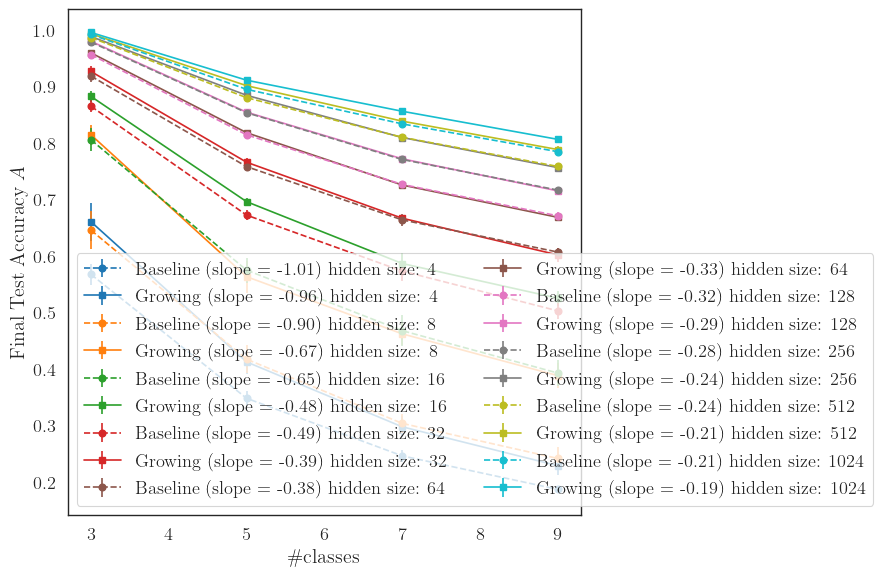

In [ ]:
plt.figure(figsize=(8, 6))

fixed_lr = 0.0003
fixed_ds = 32768

# Define a colormap with as many unique colors as hidden sizes
colors = plt.cm.tab10(np.linspace(0, 1, len(hidden_sizes)))


def extract_final_accuracy(df):
    # Create columns with final test accuracy and its standard deviation
    df = df.copy()
    df["final_test_accuracy"] = df["test_accuracy_mean"].apply(lambda arr: arr[-1])
    df["final_test_accuracy_std"] = df["test_accuracy_std"].apply(lambda arr: arr[-1])
    grouped = df.groupby(level="n_classes")[
        ["final_test_accuracy", "final_test_accuracy_std"]
    ].mean()
    return grouped["final_test_accuracy"], grouped["final_test_accuracy_std"]


for i, size in enumerate(hidden_sizes):
    # Select the rows matching fixed_lr, fixed_ds, and size
    baseline_subset = processed_baseline[
        (processed_baseline.index.get_level_values("lr") == fixed_lr)
        & (processed_baseline.index.get_level_values("dataset_size") == fixed_ds)
        & (processed_baseline.index.get_level_values("hidden_size") == size)
    ]
    growing_subset = processed_growing[
        (processed_growing.index.get_level_values("lr") == fixed_lr)
        & (processed_growing.index.get_level_values("dataset_size") == fixed_ds)
        & (processed_growing.index.get_level_values("hidden_size") == size)
    ]

    baseline_acc, baseline_std = extract_final_accuracy(baseline_subset)
    growing_acc, growing_std = extract_final_accuracy(growing_subset)

    # Fit a linear model in log–log space to get the scaling exponent.
    log_nc = np.log(baseline_acc.index.values.astype(float))
    log_baseline = np.log(baseline_acc.values)
    log_growing = np.log(growing_acc.values)

    slope_baseline, intercept_baseline = np.polyfit(log_nc, log_baseline, 1)
    slope_growing, intercept_growing = np.polyfit(log_nc, log_growing, 1)

    plt.errorbar(
        baseline_acc.index,
        baseline_acc.values,
        yerr=baseline_std.values,
        fmt="o--",
        color=colors[i],
        label=f"Baseline (slope = {slope_baseline:.2f}) hidden size: {size}",
    )
    plt.errorbar(
        growing_acc.index,
        growing_acc.values,
        yerr=growing_std.values,
        fmt="s-",
        color=colors[i],
        label=f"Growing (slope = {slope_growing:.2f}) hidden size: {size}",
    )

# Optionally, uncomment these if you wish to use log scales
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("\\#classes")
plt.ylabel("Final Test Accuracy $A$")
plt.legend(ncol=2)
plt.tight_layout()

# plt.savefig(
#     fig_dir
#     + f"classification_scaling_accuracy_classes_{fixed_lr}_{fixed_ds}_{epochs[-1]}.pdf"
# )
# plt.savefig(
#     fig_dir
#     + f"classification_scaling_accuracy_classes_{fixed_lr}_{fixed_ds}_{epochs[-1]}.svg"
# )
# plt.savefig(
#     fig_dir
#     + f"classification_scaling_accuracy_classes_{fixed_lr}_{fixed_ds}_{epochs[-1]}.png"
# )